In [2]:
import gdown

gdown.download('https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar',
               './Task07_Pancreas.tar')

Downloading...
From: https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar
To: c:\New folder\Task07_Pancreas.tar
100%|██████████| 12.3G/12.3G [43:34<00:00, 4.70MB/s]  


'./Task07_Pancreas.tar'

In [3]:
!tar -xf ./Task07_Pancreas.tar

In [5]:
!unzip /content/drive/MyDrive/DentalPanoramicXrays.zip -d /content/DP

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
import os
import glob
import json
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load and preprocess CT scan data
def load_ct_scan(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata().astype(np.float32)  # Ensure float32
    # Extract the middle slice and resize
    middle_slice = img_data[:, :, img_data.shape[2] // 2]
    return resize(middle_slice, (112, 112), anti_aliasing=True)

def load_ct_scan_dataset(ct_scan_paths):
    return np.array([load_ct_scan(path) for path in ct_scan_paths])

# Load dental X-ray data
def load_dental_xray(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(112, 112))  # Resize to match CT scans
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    return img_array.astype(np.float32)

def load_xray_dataset(xray_paths):
    return np.array([load_dental_xray(path) for path in xray_paths])

# Load implant placement labels
def load_labels_for_ct_scans(label_paths):
    return np.array([load_ct_scan(path) for path in label_paths])

# Extract implant coordinates from label data
def extract_coordinates(label_data):
    coordinates = []
    for label in label_data:
        non_zero_indices = np.argwhere(label > 0)
        if non_zero_indices.size > 0:
            coordinates.append(non_zero_indices[0][:2])  # Only x and y coordinates
        else:
            coordinates.append([0.0, 0.0])  # Default to zero coordinates
    return np.array(coordinates, dtype=np.float32)

# Build a pretrained CNN model using MobileNetV2
def build_cnn(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(2, dtype='float32')(x)  # Use float32 for output
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Load JSON mapping file
def load_json_mapping(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# Set paths
ct_scan_dataset_path = './Task07_Pancreas/imagesTr'
xray_dataset_path = 'C:\\dental project\\DentalPanoramicXrays'
json_mapping_path = './Task07_Pancreas/dataset.json'

# Load JSON mapping
mapping = load_json_mapping(json_mapping_path)

# Extract paths from JSON mapping, limiting to 50 samples
ct_scan_paths = [os.path.join("./Task07_Pancreas", entry['image']) for entry in mapping['training']][:200]
label_paths = [os.path.join("./Task07_Pancreas", entry['label']) for entry in mapping['training']][:200]
xray_images_paths = glob.glob(os.path.join(xray_dataset_path, '**/*.png'), recursive=True)[:200]  # Limit X-ray paths

# Load datasets with only 50 samples
ct_scans = load_ct_scan_dataset(ct_scan_paths)
xray_images = load_xray_dataset(xray_images_paths)  # Load only 50 X-ray images
label_data = load_labels_for_ct_scans(label_paths)

# Extract implant coordinates from labels
implant_labels = extract_coordinates(label_data)

# Ensure ct_scans has 4 dimensions (adding channel dimension)
ct_scans = np.expand_dims(ct_scans, axis=-1)  # Shape (50, 112, 112, 1)

# Convert ct_scans to 3 channels by repeating the single channel
ct_scans = np.repeat(ct_scans, 3, axis=-1)  # Shape (50, 112, 112, 3)

# Combine CT scans and X-ray images into a single dataset
combined_images = np.concatenate((ct_scans, xray_images), axis=0)
combined_labels = np.concatenate((implant_labels, implant_labels), axis=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

# Create a tf.data Dataset for efficient loading
train_dataset = Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = Dataset.from_tensor_slices((X_val, y_val)).batch(16)

# Build and compile the model
input_shape = (112, 112, 3)  # Shape of input images (channels last)
cnn_model = build_cnn(input_shape)

# Use Adam optimizer for better convergence
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)



C:\Users\chaud\AppData\Local\Temp\ipykernel_5320\3513121249.py:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 25.5303 - val_loss: 405.7021
Epoch 2/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - loss: 24.2008 - val_loss: 399.9154
Epoch 3/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - loss: 16.8257 - val_loss: 407.0716
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Validation MSE: 407.07159423828125
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


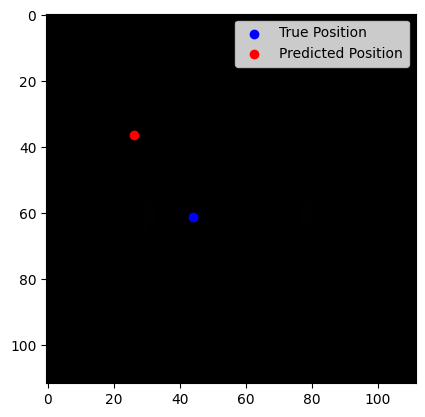

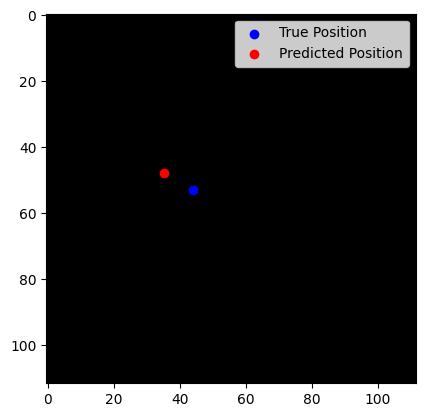

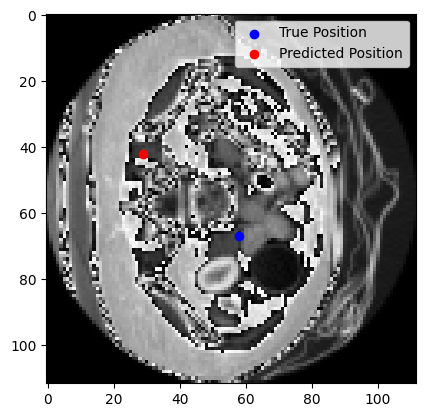

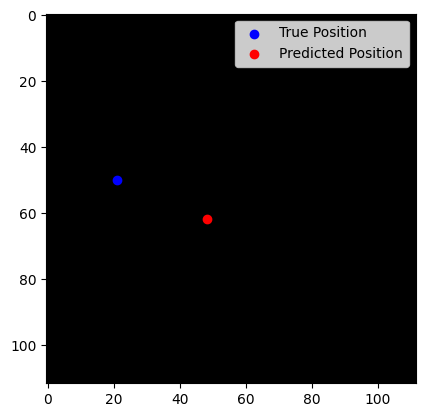

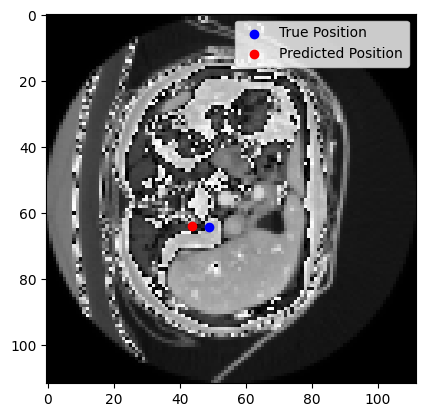

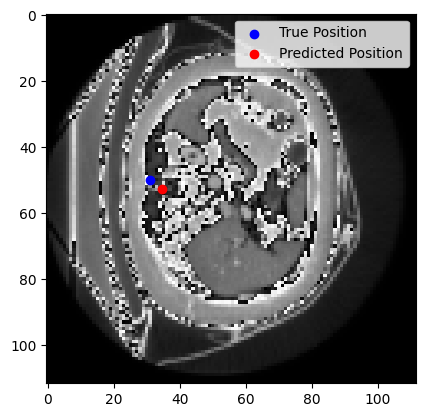

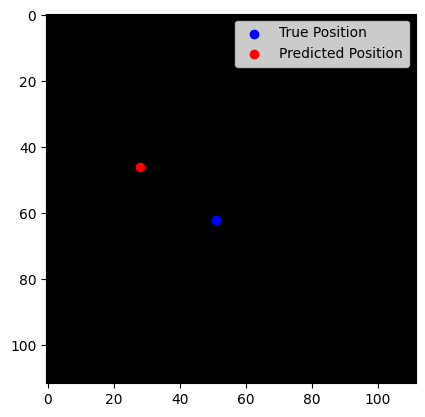

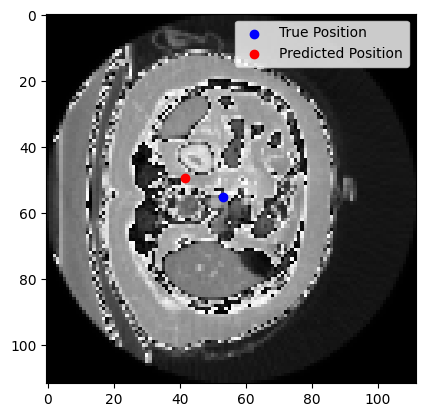

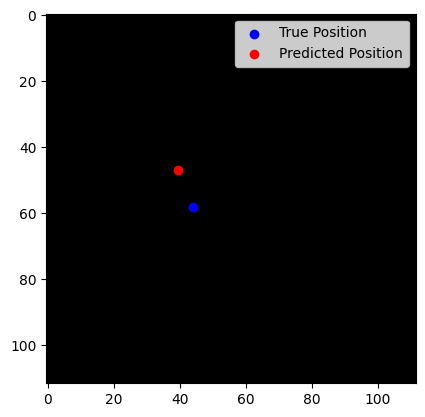

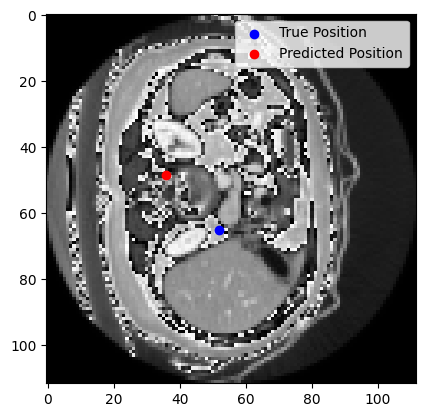

In [24]:

# Train the model
cnn_model.fit(train_dataset,
               validation_data=val_dataset,
               epochs=10000,  # Start with fewer epochs
               callbacks=[early_stopping, model_checkpoint])

# Validate the model
def evaluate_model(model, val_dataset):
    predictions = model.predict(val_dataset)
    y_val = np.concatenate([y for _, y in val_dataset], axis=0)
    mse = np.mean((predictions - y_val) ** 2)
    return mse

validation_mse = evaluate_model(cnn_model, val_dataset)
print(f"Validation MSE: {validation_mse}")

# Visualize predictions
def plot_predictions(model, X_val, y_val, num_samples=10):
    predictions = model.predict(X_val)
    for i in range(num_samples):
        plt.figure()
        plt.imshow(X_val[i].astype(np.uint8), cmap='gray')
        plt.scatter([y_val[i, 0]], [y_val[i, 1]], color='blue', label='True Position')
        plt.scatter([predictions[i, 0]], [predictions[i, 1]], color='red', label='Predicted Position')
        plt.legend()
        plt.show()

plot_predictions(cnn_model, X_val, y_val)

In [8]:
pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/12.9 MB 4.6 MB/s eta 0:00:03
   ------- -------------------------------- 2.4/12.9 MB 4.6 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.9 MB 3.5 MB/s eta 0:00:03
   -------- ------------------------------- 2.9/12.9 MB 2.8 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/12.9 MB 2.7 MB/s eta 0:00:04
   ----------- ---------------------------- 3.7/12.9 MB 2.5 MB/s eta 0:00:04
   ----------- ---------------------------- 3.7/12.9 MB 2.5 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.9 MB 2.2 MB/s eta 0:00:05
   ------------- -------------------------- 4.2/12.9 MB 2.0 MB/s eta 0:00:05
   ------------- -------------------------- 4.5/12.9 MB 1.9 MB/s eta 0:00:05
   -------------- ------------------------- 4.7/12.9 MB 1.9 MB/s eta 0:00:05
   ----------